In [161]:
import os
import copy
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    load_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from experiments.create_state import get_state
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from typing import Tuple
from qiskit_aer import Aer

%matplotlib inline

In [162]:
results_dir = "results/runs_shell_2"
run_range = list(range(1, 11))
#qubit_range = [3, 4, 5, 6, 7, 8]
qubit_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

In [163]:
def load_results(results_dir, state_type, qubit_range, eps_values) -> Tuple[dict,dict]:
    #[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
    original_results_dict = {
        "num_qubits": [],
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }

    modified_results_dict = copy.deepcopy(original_results_dict)

    for (r_dir, st_type, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
        if not num_qubits in original_results_dict["num_qubits"]: 
            original_results_dict["num_qubits"] += [num_qubits]
            modified_results_dict["num_qubits"] += [num_qubits]

        original_results_dict[eps] += [[]]
        modified_results_dict[eps] += [[]]

        for run_idx in run_range:
            fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
            original_results_dict[eps][-1] += [data_original.round(4)]

            fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
            modified_results_dict[eps][-1]+= [data_modified.round(4)]
    
    return original_results_dict, modified_results_dict


def compute_statistics(results_dict: dict) -> Tuple[dict, dict]: 
    default_dict = {
        "num_qubits": qubit_range,
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }
    mean_results_dict = copy.deepcopy(default_dict)
    stds_results_dict = copy.deepcopy(default_dict)

    #stds_original_results_dict = copy.deepcopy(default_dict)
    #stds_modified_results_dict = copy.deepcopy(default_dict)

    for eps in eps_values:
        mean_results_dict[eps] = np.mean(results_dict[eps], axis=1)
        stds_results_dict[eps] = np.std(results_dict[eps], axis=1).round(2)

        #mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
        #stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)
    return mean_results_dict, stds_results_dict


def to_dataframe(results_dict: dict) -> pd.DataFrame:
    df_results = pd.DataFrame(results_dict)
    df_results = df_results.set_index("num_qubits")
    return df_results

def get_state_vector(quantum_circuit):
    sv_sim = Aer.get_backend("statevector_simulator")
    job = sv_sim.run(quantum_circuit)
    result = job.result()
    state_vector = result.get_statevector()
    return state_vector.data

def get_loaded_states(results_dir, state_type, execution_range, n_qubits, eps_value) -> Tuple[np.ndarray, np.ndarray]:

    sv_list_original = []
    sv_list_modified = []

    for n_run in range(1, execution_range+1):
        original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        original_circuit = load_circuit(original_circuit_file_name)

        parameters_original_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"original_xbest_{n_qubits}qb_{eps_value}eps.csv")
        parameters_original = np.loadtxt(parameters_original_filename, delimiter=",")


        modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        modified_circuit = load_circuit(modified_circuit_file_name)

        parameters_modified_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"modified_xbest_{n_qubits}qb_{eps_value}eps.csv")
        parameters_modified = np.loadtxt(parameters_modified_filename, delimiter=",")

        p_original_circuit = original_circuit.assign_parameters(parameters_original)
        sv_original = get_state_vector(p_original_circuit)
        sv_list_original += [sv_original]

        p_modified_circuit = modified_circuit.assign_parameters(parameters_modified)
        sv_modified = get_state_vector(p_modified_circuit)
        sv_list_modified += [sv_modified]

    sv_mean_original = np.mean(sv_list_original, axis=0)
    sv_mean_modified = np.mean(sv_list_modified, axis=0)

    return sv_mean_original, sv_mean_modified

### Normal distribution $(\mu = 0.5, \sigma = 0.4)$

In [164]:
state_type = "normal"

In [165]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [166]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.88666,0.95205
4,0.02770,0.02770,0.00560,0.94229
5,0.02670,0.02670,0.00650,0.00600
6,0.02590,0.02590,0.00650,0.01304
7,0.02550,0.02550,0.00640,0.00304
8,0.02520,0.02520,0.10578,0.00240
9,0.02510,0.31747,0.00640,0.00249
10,0.12258,0.02510,0.10570,0.00275
11,0.02500,0.02500,0.00633,0.00333


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.81050,0.82833
4,0.02750,0.02750,0.00562,0.97106
5,0.02650,0.02650,0.75030,0.00303
6,0.11810,0.02580,0.00650,0.75010
7,0.02530,0.02530,0.50320,0.00304
8,0.02510,0.02510,0.00640,0.00201
9,0.02500,0.02500,0.00640,0.10385
10,0.06900,0.02490,0.00630,0.75047
11,0.02490,0.12238,0.77536,0.10156


In [167]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,True,True
5,False,False,True,False
6,True,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,False,True
10,False,False,False,True
11,False,True,True,True


In [168]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


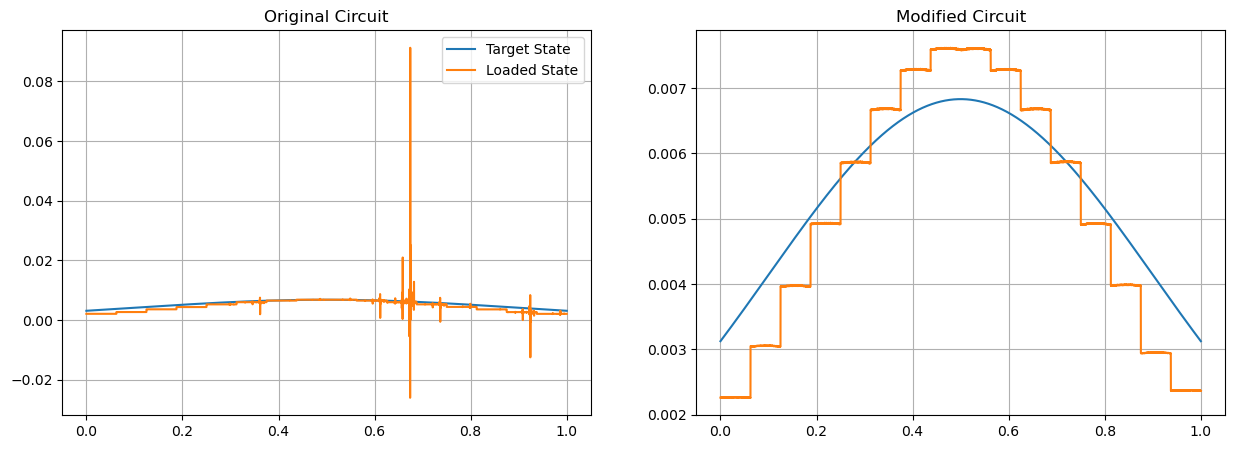

In [169]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.4})


x_points = np.linspace(0, 1, 2**n_qubits)

fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("Original Circuit")
axes[0].plot(x_points, target_state, label="Target State")
axes[0].plot(x_points, sv_mean_original, label="Loaded State")
axes[0].grid()
axes[0].legend(loc="best")

axes[1].set_title("Modified Circuit")
axes[1].plot(x_points, target_state, label="Target State")
axes[1].plot(x_points, sv_mean_modified, label="Loaded State")
axes[1].grid()
axes[0].legend(loc="best")

### $log$-Normal Distribution $(s= 1, \mu = 0.1, \sigma = 0.3)$

In [170]:
state_type = "lognormal"

In [171]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [172]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.89517,0.92659
4,0.21620,0.21620,0.04173,0.94992
5,0.22560,0.22560,0.03797,0.02171
6,0.22200,0.22200,0.03088,0.01686
7,0.21910,0.21910,0.03100,0.01816
8,0.21750,0.21750,0.02729,0.02278
9,0.21670,0.21670,0.03034,0.03532
10,0.21620,0.21620,0.02586,0.01625
11,0.29440,0.21600,0.02606,0.01701


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.89654,0.93833
4,0.21110,0.21110,0.04137,0.91628
5,0.22210,0.22210,0.77221,0.03246
6,0.21940,0.21940,0.03053,0.75435
7,0.21710,0.21710,0.51648,0.01878
8,0.29413,0.21570,0.12298,0.02286
9,0.21500,0.21500,0.12198,0.02012
10,0.21461,0.21460,0.02448,0.75388
11,0.21510,0.29291,0.75627,0.01914


In [173]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,True
4,False,False,False,False
5,False,False,True,True
6,False,False,False,True
7,False,False,True,True
8,True,False,True,True
9,False,False,True,False
10,False,False,False,True
11,False,True,True,True


In [174]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


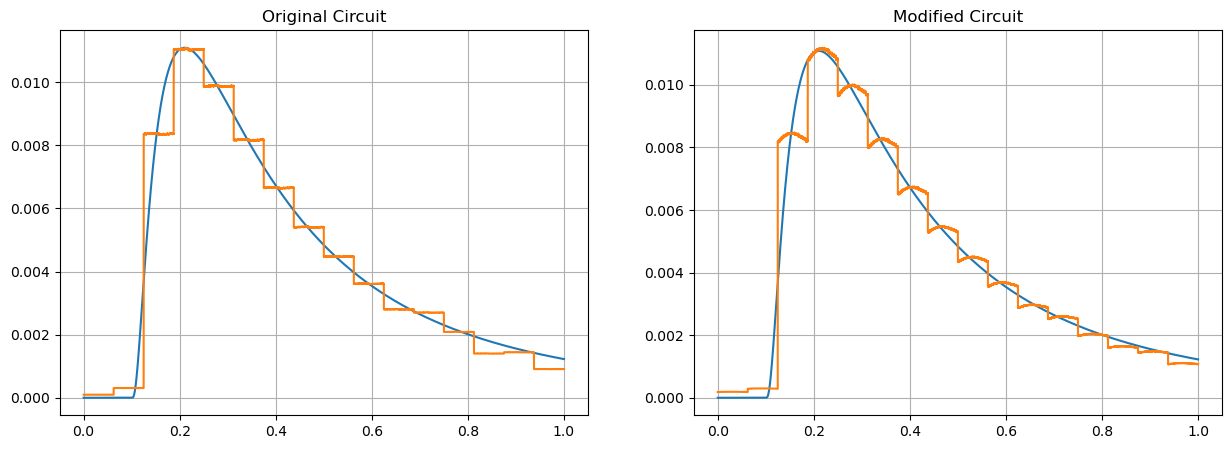

In [175]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "s": 1, "loc": 0.1, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)

fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("Original Circuit")
axes[0].plot(x_points, target_state, label="Target Probs")
axes[0].plot(x_points, sv_mean_original, label="Target Probs")
axes[0].grid()

axes[1].set_title("Modified Circuit")
axes[1].plot(x_points, target_state, label="Target Probs")
axes[1].plot(x_points, sv_mean_modified, label="Target Probs")
axes[1].grid()

### Bimodal Distribution $(\mu_1 = 0.25, \sigma_1 = 0.3; \mu_2 = 0.75, \sigma_2 = 0.6)$

In [176]:
state_type = "bimodal"

In [177]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [178]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.01030,0.01030,0.83639,0.88487
4,0.01000,0.01000,0.00210,0.97665
5,0.00940,0.00940,0.00985,0.00172
6,0.00890,0.00890,0.00230,0.00092
7,0.00870,0.00870,0.00231,0.00615
8,0.00860,0.00860,0.00220,0.00340
9,0.00850,0.00850,0.00478,0.19960
10,0.00850,0.00850,0.00220,0.10375
11,0.10763,0.00850,0.10198,0.00205


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.01030,0.01030,0.94898,0.87465
4,0.01000,0.01000,0.00261,0.96834
5,0.00930,0.00930,0.74460,0.00095
6,0.00890,0.00890,0.00230,0.74700
7,0.00870,0.00870,0.50001,0.00102
8,0.00850,0.00850,0.00222,0.00218
9,0.00850,0.00850,0.00220,0.00086
10,0.00840,0.00840,0.00220,0.77634
11,0.00840,0.00840,0.75040,0.00069


In [179]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,False
4,False,False,True,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,True,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [180]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


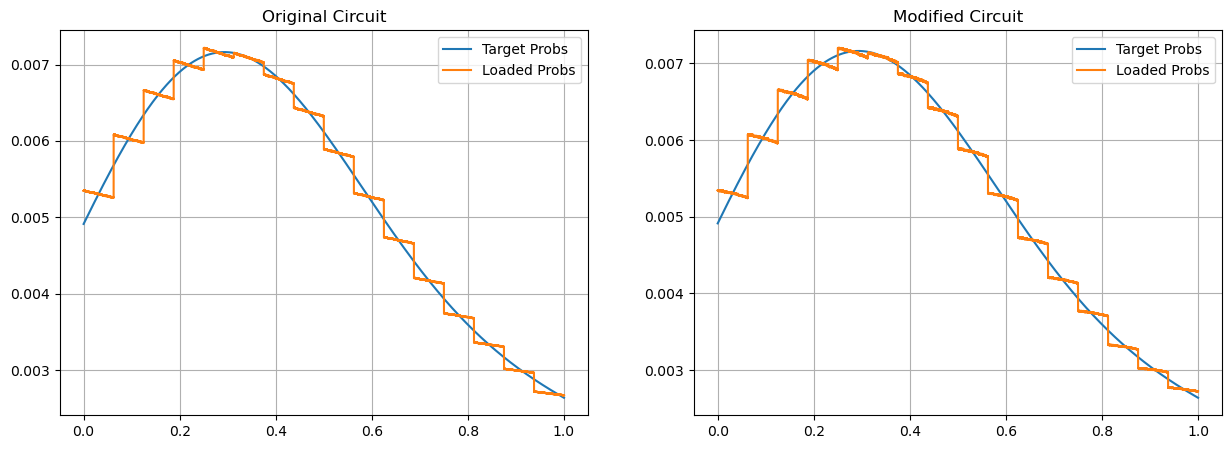

In [181]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc_bim1": 0.25, "scale_bim1": 0.3, "loc_bim2": 0.75, "scale_bim2": 0.6})


x_points = np.linspace(0, 1, 2**n_qubits)

fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("Original Circuit")
axes[0].plot(x_points, target_state, label="Target Probs")
axes[0].plot(x_points, sv_mean_original, label="Loaded Probs")
axes[0].grid()
axes[0].legend(loc="best")

axes[1].set_title("Modified Circuit")
axes[1].plot(x_points, target_state, label="Target Probs")
axes[1].plot(x_points, sv_mean_modified, label="Loaded Probs")
axes[1].grid()
axes[1].legend(loc="best")

### Triangular $(c=1, \mu = 0.5, \sigma = 0.5)$

In [182]:
state_type = "triangular"

In [183]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [184]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.33771,0.23722,0.86268,0.77670
4,0.01160,0.01160,0.74343,0.95648
5,0.11098,0.01220,0.00350,0.99833
6,0.01230,0.01230,0.92832,0.20071
7,0.11116,0.01240,1.00000,0.99968
8,0.01240,0.20992,0.10333,1.00000
9,0.01240,0.20984,0.20296,0.97248
10,0.11116,0.11116,0.74369,0.72005
11,0.68018,0.44048,0.89381,1.00000


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.23228,0.22086,0.96471,0.89306
4,0.01120,0.01120,0.74751,0.92409
5,0.74895,0.77268,0.81740,0.97602
6,0.01200,0.01200,0.00360,0.80599
7,0.97232,0.97021,0.51360,0.97012
8,0.01200,0.01200,0.98025,0.00124
9,0.98880,1.00000,0.10333,0.97719
10,0.01200,0.01200,0.99830,0.75263
11,1.00000,1.00000,0.75200,0.99999


In [185]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,True
4,False,False,True,False
5,True,True,True,False
6,False,False,False,True
7,True,True,False,False
8,False,False,True,False
9,True,True,False,True
10,False,False,True,True
11,True,True,False,False


In [186]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


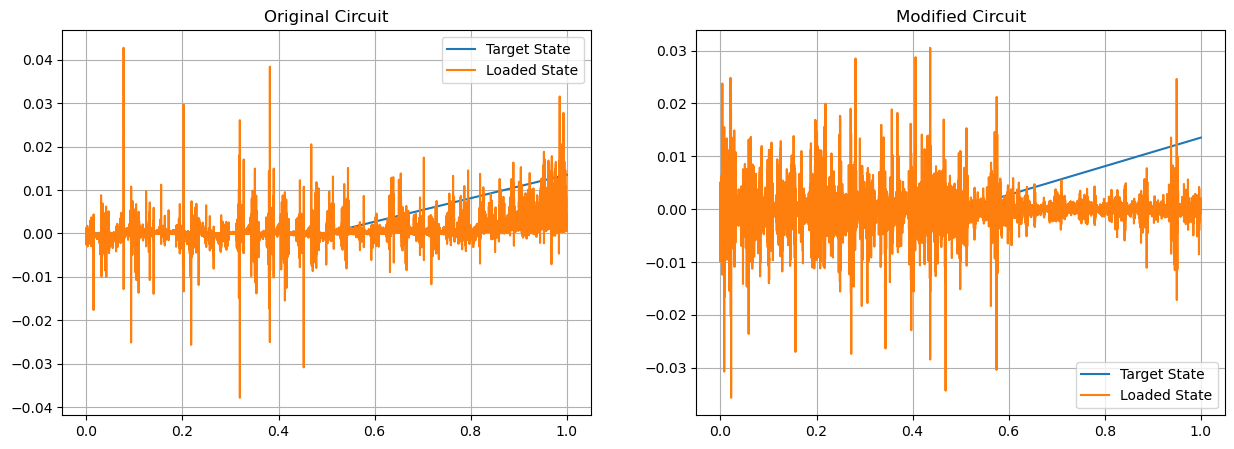

In [187]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "c": 1, "loc": 0.5, "scale": 0.5})


x_points = np.linspace(0, 1, 2**n_qubits)

fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("Original Circuit")
axes[0].plot(x_points, target_state, label="Target State")
axes[0].plot(x_points, sv_mean_original, label="Loaded State")
axes[0].grid()
axes[0].legend(loc="best")

axes[1].set_title("Modified Circuit")
axes[1].plot(x_points, target_state, label="Target State")
axes[1].plot(x_points, sv_mean_modified, label="Loaded State")
axes[1].grid()
axes[1].legend(loc="best")

### Laplace $(\mu = 0.5, \sigma = 0.2)$

In [188]:
state_type = "laplace"

In [189]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [190]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.87824,0.84678
4,0.11770,0.11770,0.02742,0.94525
5,0.11710,0.11710,0.03330,0.01087
6,0.11530,0.11530,0.03577,0.01609
7,0.11410,0.11410,0.03260,0.02403
8,0.11340,0.11340,0.03169,0.01483
9,0.11300,0.11300,0.03595,0.01670
10,0.11280,0.11280,0.03238,0.01657
11,0.11270,0.20094,0.03221,0.01519


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.91708,0.89953
4,0.11530,0.11530,0.02678,0.95969
5,0.11490,0.11490,0.73761,0.01283
6,0.11320,0.11320,0.03187,0.74977
7,0.28960,0.11200,0.51574,0.01956
8,0.19873,0.11140,0.03216,0.01310
9,0.11100,0.11100,0.03496,0.01331
10,0.11090,0.11090,0.03159,0.77892
11,0.11080,0.11080,0.77848,0.01257


In [191]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,True
4,False,False,False,True
5,False,False,True,True
6,False,False,False,True
7,True,False,True,False
8,True,False,True,False
9,False,False,False,False
10,False,False,False,True
11,False,False,True,False


In [192]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

/home/ismael/anaconda3/envs/sanches-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


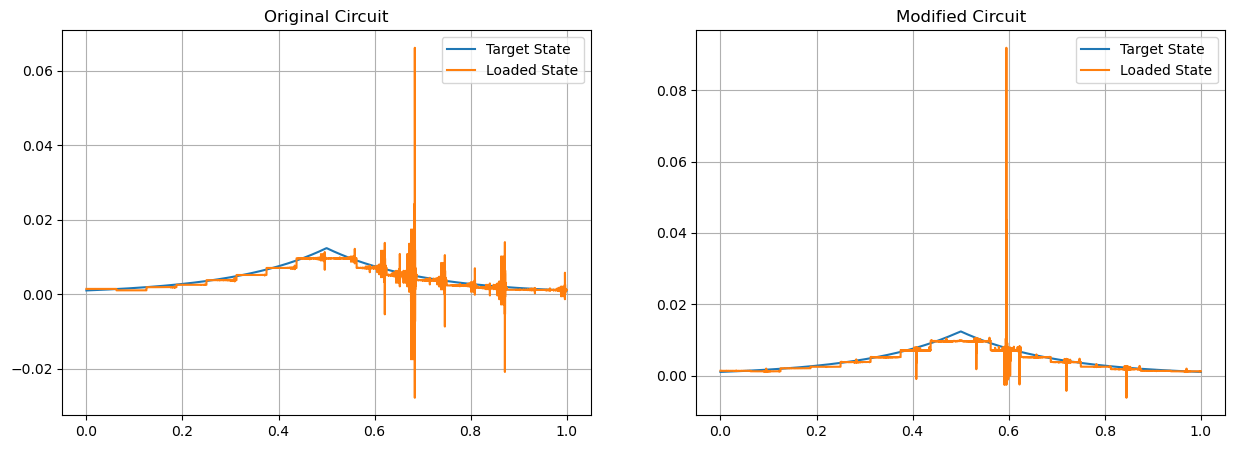

In [193]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.2})


x_points = np.linspace(0, 1, 2**n_qubits)

fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
axes[0].set_title("Original Circuit")
axes[0].plot(x_points, target_state, label="Target State")
axes[0].plot(x_points, sv_mean_original, label="Loaded State")
axes[0].grid()
axes[0].legend(loc="best")

axes[1].set_title("Modified Circuit")
axes[1].plot(x_points, target_state, label="Target State")
axes[1].plot(x_points, sv_mean_modified, label="Loaded State")
axes[1].grid()
axes[1].legend(loc="best")